In [2]:
import nibabel as nib
import ants
from ants.plotting import plot
import numpy as np

In [3]:
#read mapped image
mapped_image_path = '/Users/dennis.jungchildmind.org/Desktop/subcortical_test/I38_new_confidence/warped_template.nii.gz'
mapped_image = ants.image_read(mapped_image_path)
print(mapped_image)


ANTsImage (RSP)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (640, 1400, 1600)
	 Spacing    : (0.12, 0.12, 0.12)
	 Origin     : (-37.6338, 73.1786, 94.9927)
	 Direction  : [ 1.  0.  0.  0. -0. -1.  0. -1.  0.]



In [4]:
mapped_image_np = mapped_image.numpy()

In [5]:
print(mapped_image_np.shape)

(640, 1400, 1600)


In [ ]:
print(np.unique(mapped_image_np))

In [6]:
original_image_path = '/Users/dennis.jungchildmind.org/Desktop/subcortical_test/I38_new_confidence/orig_img_resampled.nii'
original_image = ants.image_read(original_image_path)
print(original_image)
plot(original_image,axis=2)

ValueError: File /Users/dennis.jungchildmind.org/Desktop/subcortical_test/I38_new_confidence/orig_img_resampled.nii does not exist!

In [30]:
tmp = nib.load(template_path)

In [ ]:
from matplotlib import pyplot as plt
print(tmp.get_fdata().shape)
print(np.unique(tmp.get_fdata()).shape)


(193, 229, 193)
(64040,)


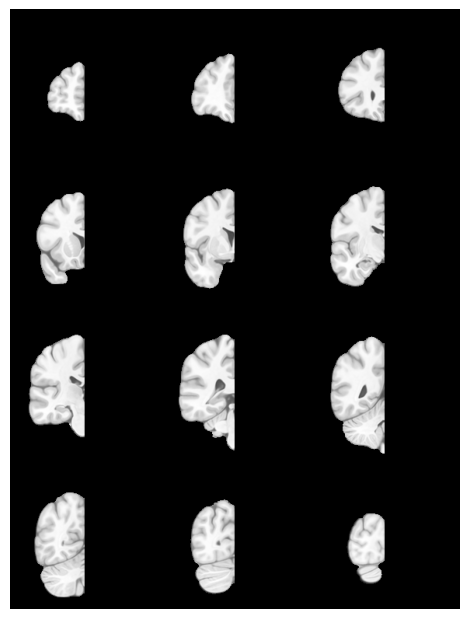

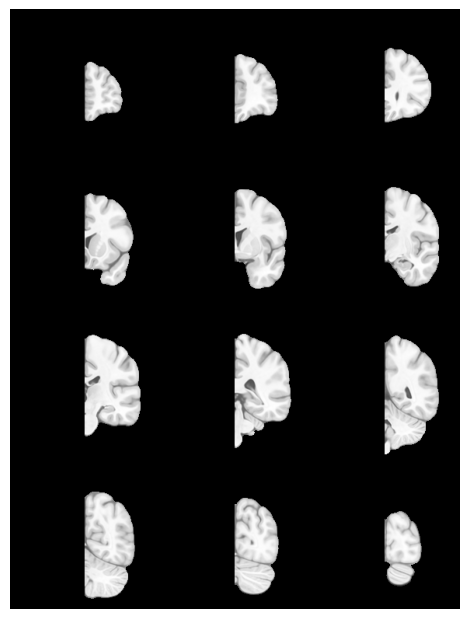

In [29]:
template_path = '/Users/dennis.jungchildmind.org/Desktop/atlas/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_t1_tal_nlin_asym_09c.nii'
headmask_path = '/Users/dennis.jungchildmind.org/Desktop/atlas/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_t1_tal_nlin_asym_09c_mask.nii'#only has t
template = ants.image_read(template_path)
headmask = ants.image_read(headmask_path)
masked_template = ants.mask_image(template, headmask,level=1,binarize=False)#this removes the skull right away
# Get numpy array
data = masked_template.numpy()

# Create left hemisphere mask
# In MNI space with ANTs, need to check orientation
center_x = data.shape[0] // 2
left_mask = np.zeros_like(data)
left_mask[:center_x, :, :] = 1

# Create ANTs image from mask
mask_img = ants.from_numpy(left_mask, origin=masked_template.origin, 
                           spacing=masked_template.spacing, direction=masked_template.direction)
left_hemisphere = masked_template * mask_img
plot(left_hemisphere,axis=1)
# Save result
ants.image_write(left_hemisphere, 'mni_icbm152_t1_tal_nlin_asym_09c_left_hemi.nii')

#do for right hemisphere
right_mask = np.zeros_like(data)
right_mask[center_x:, :, :] = 1
right_hemisphere = masked_template * ants.from_numpy(right_mask, origin=masked_template.origin, 
                           spacing=masked_template.spacing, direction=masked_template.direction)
plot(right_hemisphere,axis=1)
ants.image_write(right_hemisphere, 'mni_icbm152_t1_tal_nlin_asym_09c_right_hemi.nii')

In [43]:


# Define file paths
template_path = '/Users/dennis.jungchildmind.org/Desktop/atlas/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_t2_tal_nlin_asym_09c.nii'
headmask_path = '/Users/dennis.jungchildmind.org/Desktop/atlas/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_t1_tal_nlin_asym_09c_mask.nii'#only has t
atlas_path = '/Users/dennis.jungchildmind.org/Desktop/subcortical_test/Schaefer2018_400Parcels_7Networks_order_Tian_Subcortex_S1_3T_MNI152NLin2009cAsym_1mm.nii.gz'

# Read images
template = ants.image_read(template_path)
headmask = ants.image_read(headmask_path)
atlas = ants.image_read(atlas_path)

#make sure the shape of the atlas and template are the same
if atlas.shape != template.shape:
    print("The shape of the atlas and template are not the same")
    exit()
else:
    print("The shape of the atlas and template are the same")


The shape of the atlas and template are the same


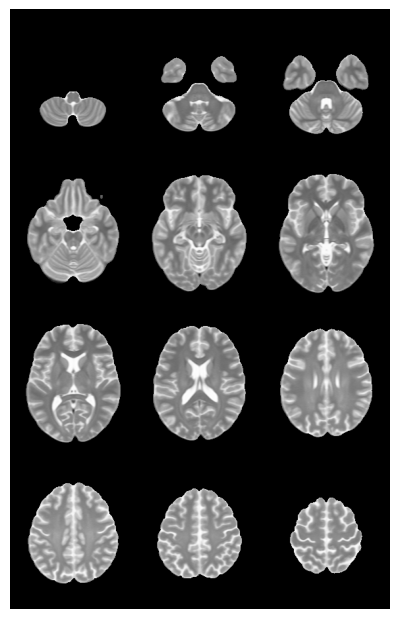

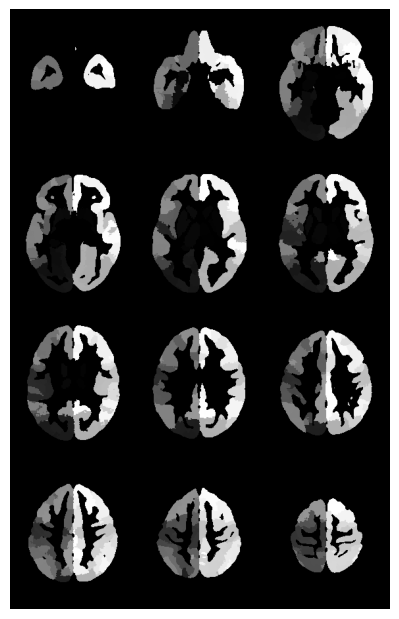

In [44]:
masked_template = ants.mask_image(template, headmask,level=1,binarize=False)#this removes the skull right away
plot(masked_template,axis=2)
plot(atlas,axis=2)

In [45]:
#get labels from the atlas so that I can generate a mask for the left or right hemisphere
atlas_label = atlas.numpy()
#just manual separate of lh and rh 
# Fix: Combine hardcoded values with range for RH labels according to the comment
rh_label = list(range(1, 9)) + list(range(217, 417))
lh_label = list(range(9, 217))  # 9 through 216 inclusive

#generate a mask for the left hemisphere
left_hemisphere_mask = np.isin(atlas_label, lh_label)
right_hemisphere_mask = np.isin(atlas_label, rh_label)
# Convert to ANTs images
# Method 1: Using from_numpy (RECOMMENDED)
left_hemi_mask_ants = ants.from_numpy(
    left_hemisphere_mask.astype('float32'),  # Convert bool to float
    origin=atlas.origin,
    spacing=atlas.spacing,
    direction=atlas.direction
)

right_hemi_mask_ants = ants.from_numpy(
    right_hemisphere_mask.astype('float32'),
    origin=atlas.origin,
    spacing=atlas.spacing,
    direction=atlas.direction
)


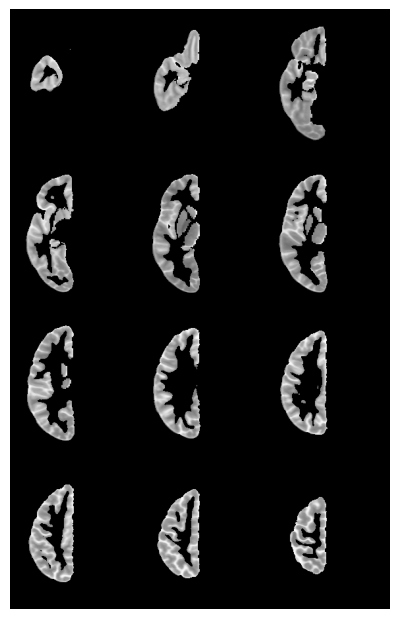

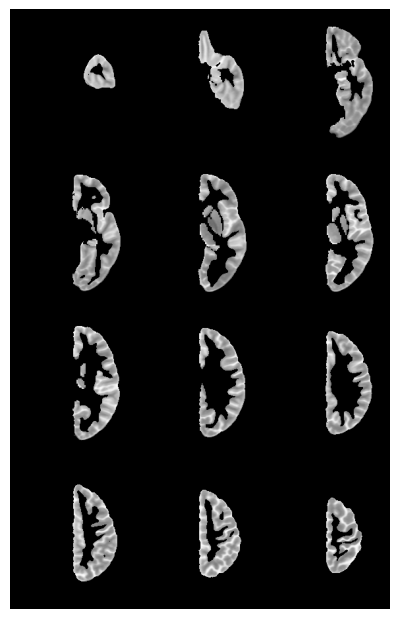

Left hemisphere mask: (193, 229, 193)
Right hemisphere mask: (193, 229, 193)
Left hemisphere voxels: 586267
Right hemisphere voxels: 586344


In [46]:
masked_template_lh = ants.mask_image(masked_template,left_hemi_mask_ants,level=1,binarize=False)
plot(masked_template_lh,axis=2)
masked_template_rh = ants.mask_image(masked_template,right_hemi_mask_ants,level=1,binarize=False)
plot(masked_template_rh,axis=2)

#save the masked templates
# Save the masks
ants.image_write(masked_template_lh, 'mni_icbm152_t2_tal_nlin_asym_09c_masked_lh_only.nii.gz')
ants.image_write(masked_template_rh, 'mni_icbm152_t2_tal_nlin_asym_09c_masked_rh_only.nii.gz')

print(f"Left hemisphere mask: {left_hemi_mask_ants.shape}")
print(f"Right hemisphere mask: {right_hemi_mask_ants.shape}")
print(f"Left hemisphere voxels: {np.sum(left_hemisphere_mask)}")
print(f"Right hemisphere voxels: {np.sum(right_hemisphere_mask)}")